<a href="https://colab.research.google.com/github/toraaglobal/Fedpapers/blob/master/fedpaperAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Supervised and Unsupervised Approach in Resolving Publication Mistery in US Histroy: Text Mining of Fedpapers

In [1]:
## packages

import inspect
import json
import nltk
import pandas as pd
import sklearn
from sklearn.cluster import KMeans
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
## For Stemming
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import os
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk import tokenize

#os.chdir("C:\\Users\\teeja\\Dropbox\\AppliedDataScience\\tool")

%matplotlib inline


nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
## Mount the gdrive
from google.colab import drive
drive.mount('/content/drive')


## change directry to the gdrive

os.chdir('./drive/My Drive/Colab Notebooks/fedpapers_Analysis')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
## Some helper function

def generate_wordcloud(text, max_font_size=50, max_words=100, background_color="white"):
    '''generate word cloud from text '''
    wordcloud = WordCloud(max_font_size=max_font_size, max_words=max_words, background_color=background_color).generate(text)
    #display generated image
    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    #figname = str(text) + '.png'
    #plt.savefig(figname)
    plt.show()
    
def generate_freq_plot(text,n=20, cumulative=False):
  '''generate frequency plot of words distribution in a text document and return word tokens '''
  #from nltk.probability import FreqDist
  tokens = tokenize.word_tokenize(text)
  freq = FreqDist(tokens)
  freq.plot(n, cumulative=cumulative)
  return tokens

def generate_freq_plot_from_tokens(tokens=[],n=20, cumulative=False):
    freq = FreqDist(tokens)
    freq.plot(n=n, cumulative=cumulative)
    
    
def create_vector_from_file(filepath, encoding='latin-1',min_df=5,stop_word='english', option ='C', ngram_range=(1,1), token_pattern='(?ui)\\b\\w*[a-z]{4,}\\w*\\b'):
    '''
    create_vector_from_text(filepath, encoding='latin-1', binary=True,min_df=5,stop_word='english', option ='C',ngram=False, ngram_range=(1,2))
        filepath = foldder directory containing corpus
        encoding : 'latin-1'
        binary : True/False. The default is True
        min_df : int, the default is 5
        stop_word : 'english'
        option : char 'C'/'T'. C= CountVectorizer, T= TfideVectorizer. Default is C=CountVectorizer.
        ngram : True/False, defaul is False, if ngram reguired, set to True
        n_gram_range : default (1, 1).
        textcol : string, required, the column that contain the text data in the dataframe.
        
        
        Options:
                C : count vectorizer
                B : boolean vectorizer
                T : tf* idf Vecorizer
        
    return a vectorized text.
    
      
    '''
 
    if option == 'C':
        print(' unigram count vectorizer, set minimum document frequency to {}'.format(min_df))
        doc_vectorizer = CountVectorizer(input='filename',encoding=encoding, binary= False, min_df= min_df, stop_words= stop_word,ngram_range=ngram_range,token_pattern=token_pattern )
    elif option == 'B':
        print('unigram bool vectorizer, set minimum document frequency to {}'.format(min_df))
        doc_vectorizer = CountVectorizer(input='filename',encoding=encoding, binary=True, min_df=min_df, stop_words=stop_word, ngram_range=ngram_range,token_pattern=token_pattern)
    elif option == 'T':
        print('unigram tfidf vectorizer, set minimum document frequency to {}'.format(min_df))
        doc_vectorizer = TfidfVectorizer(input='filename',encoding=encoding, use_idf=True, min_df=min_df, stop_words=stop_word, ngram_range=ngram_range,token_pattern=token_pattern)

    else:
        print('check input parameters Options : C , B, T is required')
        sys.exit(0)

    ListOfCompletedFiles = []
    for name in os.listdir(filepath):
        print("Reading : {}".format(name))
        docname = filepath + '/' + name
        ListOfCompletedFiles.append(docname)
    print("Done...")
    #check the content of the document vector
    vecs = doc_vectorizer.fit_transform(ListOfCompletedFiles)
    columnNames = doc_vectorizer.get_feature_names()
    df = pd.DataFrame(vecs.toarray(), columns =columnNames)
    print('=' * 50)
    print(vecs.shape)
    print('=' * 50)
    print(vecs[0].toarray())

    # check the size of the contructed vocabulary
    print('='* 50)
    print('The size of the contructed vocabulary : {}'.format(len(doc_vectorizer.vocabulary_)))
    print('=' * 50)
    print('The first 20 of the contructed vocabulary \n\n' )
    print(list(doc_vectorizer.vocabulary_.items())[:20])

    # check word index in vocabulary
    print('=' * 50)
    print('check word index in vocabulary')
    word =input('Input word to get its index: ')
    index =(doc_vectorizer.vocabulary_.get(word))
    print('index of {} : {}'.format(word, index))

    return df


### Read the whole corpus into a plaintext 

In [4]:
MyCorpusReader = nltk.corpus.PlaintextCorpusReader("FedCorpus_original", '.*\.txt')
print(MyCorpusReader)
print(MyCorpusReader.raw()[1:1000])

<PlaintextCorpusReader in '/content/drive/My Drive/Colab Notebooks/fedpapers_Analysis/FedCorpus_original'>
ederalist No. 18&nbsp;||
	  
The Same Subject Continued: The Insufficiency of the Present 
        Confederation to Preserve the Union
        For the Independent Journal.

      
Author: Alexander Hamilton and James Madison

      
To the People of the State of New York:

      
AMONG the confederacies of antiquity, the most considerable was that 
        of the Grecian republics, associated under the Amphictyonic council. From 
        the best accounts transmitted of this celebrated institution, it bore 
        a very instructive analogy to the present Confederation of the American 
        States.

      
The members retained the character of independent and sovereign states, 
        and had equal votes in the federal council. This council had a general 
        authority to propose and resolve whatever it judged necessary for the 
        common welfare of Greece; to declar

### Wordcloud of the plaintext

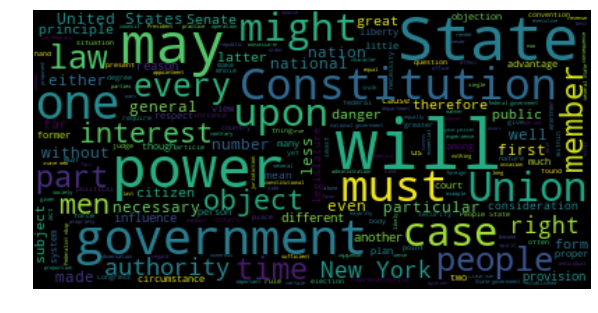

In [5]:
generate_wordcloud(MyCorpusReader.raw(), max_words=200,background_color="black")

### Frequency Plot

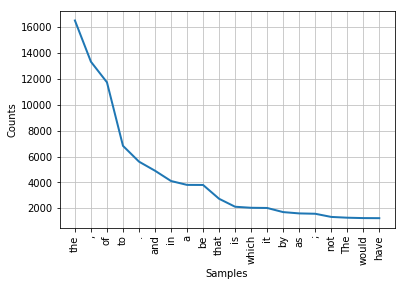

In [6]:
wordtokens = generate_freq_plot(MyCorpusReader.raw(), n=20)

### Vectorization

In [7]:
## Count vectorizer

filepath = "FedCorpus_original"
df_count = create_vector_from_file(filepath,  option ='C')

 unigram count vectorizer, set minimum document frequency to 5
Reading : dispt_fed_57.txt
Reading : dispt_fed_49.txt
Reading : dispt_fed_50.txt
Reading : dispt_fed_52.txt
Reading : dispt_fed_53.txt
Reading : dispt_fed_54.txt
Reading : dispt_fed_55.txt
Reading : dispt_fed_51.txt
Reading : dispt_fed_62.txt
Reading : dispt_fed_56.txt
Reading : dispt_fed_63.txt
Reading : Hamilton_fed_1.txt
Reading : Hamilton_fed_23.txt
Reading : Hamilton_fed_17.txt
Reading : Hamilton_fed_15.txt
Reading : Hamilton_fed_22.txt
Reading : Hamilton_fed_21.txt
Reading : Hamilton_fed_13.txt
Reading : Hamilton_fed_11.txt
Reading : Hamilton_fed_16.txt
Reading : Hamilton_fed_12.txt
Reading : Hamilton_fed_24.txt
Reading : Hamilton_fed_25.txt
Reading : Hamilton_fed_26.txt
Reading : Hamilton_fed_35.txt
Reading : Hamilton_fed_34.txt
Reading : Hamilton_fed_32.txt
Reading : Hamilton_fed_31.txt
Reading : Hamilton_fed_33.txt
Reading : Hamilton_fed_30.txt
Reading : Hamilton_fed_27.txt
Reading : Hamilton_fed_28.txt
Reading : H

In [8]:
## head of the dataframe from count vectorizer
df_count.head()

,abandon,abilities,ability,able,abolish,abolished,abolition,abridge,abridgment,abroad,absolute,absolutely,abstract,absurd,absurdity,abundant,abuse,abused,abuses,accidental,accommodated,accompanied,accomplish,accomplished,according,accordingly,account,accumulation,accuracy,accurate,accustomed,acknowledge,acknowledged,acquaintance,acquainted,acquire,acquired,acquisition,acting,action,...,warranted,wars,ways,weak,weaker,weakness,weal,wealth,wealthy,weight,weights,weighty,welfare,western,whilst,wholly,wide,willing,wisdom,wise,wisely,wish,wished,wishes,withstand,word,words,work,world,worse,worthy,writer,writers,wrong,year,years,yield,york,zeal,zealous
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,2,0,0,0,0,0,0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,5,1,0
1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,2,0,0
2,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0
3,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,9,1,2,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,1,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,3,0,2,1,0


In [9]:
## Bool vectorizer

df_bool = create_vector_from_file(filepath, option='B')

unigram bool vectorizer, set minimum document frequency to 5
Reading : dispt_fed_57.txt
Reading : dispt_fed_49.txt
Reading : dispt_fed_50.txt
Reading : dispt_fed_52.txt
Reading : dispt_fed_53.txt
Reading : dispt_fed_54.txt
Reading : dispt_fed_55.txt
Reading : dispt_fed_51.txt
Reading : dispt_fed_62.txt
Reading : dispt_fed_56.txt
Reading : dispt_fed_63.txt
Reading : Hamilton_fed_1.txt
Reading : Hamilton_fed_23.txt
Reading : Hamilton_fed_17.txt
Reading : Hamilton_fed_15.txt
Reading : Hamilton_fed_22.txt
Reading : Hamilton_fed_21.txt
Reading : Hamilton_fed_13.txt
Reading : Hamilton_fed_11.txt
Reading : Hamilton_fed_16.txt
Reading : Hamilton_fed_12.txt
Reading : Hamilton_fed_24.txt
Reading : Hamilton_fed_25.txt
Reading : Hamilton_fed_26.txt
Reading : Hamilton_fed_35.txt
Reading : Hamilton_fed_34.txt
Reading : Hamilton_fed_32.txt
Reading : Hamilton_fed_31.txt
Reading : Hamilton_fed_33.txt
Reading : Hamilton_fed_30.txt
Reading : Hamilton_fed_27.txt
Reading : Hamilton_fed_28.txt
Reading : Ham

In [10]:
## head of dataframe from bool vectorizer
df_bool.head()

,abandon,abilities,ability,able,abolish,abolished,abolition,abridge,abridgment,abroad,absolute,absolutely,abstract,absurd,absurdity,abundant,abuse,abused,abuses,accidental,accommodated,accompanied,accomplish,accomplished,according,accordingly,account,accumulation,accuracy,accurate,accustomed,acknowledge,acknowledged,acquaintance,acquainted,acquire,acquired,acquisition,acting,action,...,warranted,wars,ways,weak,weaker,weakness,weal,wealth,wealthy,weight,weights,weighty,welfare,western,whilst,wholly,wide,willing,wisdom,wise,wisely,wish,wished,wishes,withstand,word,words,work,world,worse,worthy,writer,writers,wrong,year,years,yield,york,zeal,zealous
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0


In [11]:
## tf*idf vectorizer

df_tfidf = create_vector_from_file(filepath, option='T')

unigram tfidf vectorizer, set minimum document frequency to 5
Reading : dispt_fed_57.txt
Reading : dispt_fed_49.txt
Reading : dispt_fed_50.txt
Reading : dispt_fed_52.txt
Reading : dispt_fed_53.txt
Reading : dispt_fed_54.txt
Reading : dispt_fed_55.txt
Reading : dispt_fed_51.txt
Reading : dispt_fed_62.txt
Reading : dispt_fed_56.txt
Reading : dispt_fed_63.txt
Reading : Hamilton_fed_1.txt
Reading : Hamilton_fed_23.txt
Reading : Hamilton_fed_17.txt
Reading : Hamilton_fed_15.txt
Reading : Hamilton_fed_22.txt
Reading : Hamilton_fed_21.txt
Reading : Hamilton_fed_13.txt
Reading : Hamilton_fed_11.txt
Reading : Hamilton_fed_16.txt
Reading : Hamilton_fed_12.txt
Reading : Hamilton_fed_24.txt
Reading : Hamilton_fed_25.txt
Reading : Hamilton_fed_26.txt
Reading : Hamilton_fed_35.txt
Reading : Hamilton_fed_34.txt
Reading : Hamilton_fed_32.txt
Reading : Hamilton_fed_31.txt
Reading : Hamilton_fed_33.txt
Reading : Hamilton_fed_30.txt
Reading : Hamilton_fed_27.txt
Reading : Hamilton_fed_28.txt
Reading : Ha

In [12]:
## head of dataframe from tf*idf vectorizer
df_tfidf.head()

,abandon,abilities,ability,able,abolish,abolished,abolition,abridge,abridgment,abroad,absolute,absolutely,abstract,absurd,absurdity,abundant,abuse,abused,abuses,accidental,accommodated,accompanied,accomplish,accomplished,according,accordingly,account,accumulation,accuracy,accurate,accustomed,acknowledge,acknowledged,acquaintance,acquainted,acquire,acquired,acquisition,acting,action,...,warranted,wars,ways,weak,weaker,weakness,weal,wealth,wealthy,weight,weights,weighty,welfare,western,whilst,wholly,wide,willing,wisdom,wise,wisely,wish,wished,wishes,withstand,word,words,work,world,worse,worthy,writer,writers,wrong,year,years,yield,york,zeal,zealous
0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.022113,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,...,0.032842,0.0,0.0,0.0,0.000000,0.0,0.0,0.054625,0.0,0.0,0.0,0.0,0.0,0.0,0.080151,0.000000,0.0,0.0,0.024626,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.029336,0.0,0.0,0.0,0.027313,0.000000,0.000000,0.052101,0.025111,0.0
1,0.0,0.0,0.000000,0.044017,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.040968,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.035698,0.0,0.0,0.00000,0.040968,0.00000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.079459,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.033328,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.03973,0.0,0.0,0.0,0.0,0.035698,0.0,0.0,0.036595,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.025997,0.000000,0.0
2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.032694,0.043397,0.0,0.0,0.0,0.0,0.000000,0.0,0.051003,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.04946,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.067546,0.000000,0.032365,0.000000,0.0
3,0.0,0.0,0.039622,0.019121,0.0,0.0,0.0,0.039622,0.0,0.0,0.000000,0.030286,0.0,0.0,0.0,0.0,0.029602,0.0,0.000000,0.039622,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.029602,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.059203,0.212129,0.031794,0.022587,0.027215,0.0
4,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.024662,0.0,0.000000,0.000000,0.03301,0.0,0.0,0.0,0.000000,0.023133,0.0,0.0,0.0,0.025840,0.0,0.0,0.00000,0.029655,0.02584,0.027939,0.083817,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.024124,0.020664,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.172634,0.058910,0.000000,0.018818,0.022674,0.0


## Kmeans Cluster

In [0]:
## matrix from the count vectorizer dataframe
df_count_matrix = df_count.values

In [14]:
## initialize the kmean cluster with 3 cluster assignment
kmeansCluster = KMeans(n_clusters=3)
print(kmeansCluster)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)


In [15]:
## fit the kmean cluster
kmeansCluster.fit(df_count_matrix)

# Get cluster assignment labels
labels = kmeansCluster.labels_

# Format results as a DataFrame
Myresults = pd.DataFrame([df_count.index,labels]).T
print(Myresults.head(20))

     0  1
0    0  0
1    1  0
2    2  0
3    3  0
4    4  0
5    5  1
6    6  0
7    7  0
8    8  0
9    9  0
10  10  0
11  11  0
12  12  0
13  13  0
14  14  0
15  15  1
16  16  0
17  17  0
18  18  0
19  19  0


### get all the filenames

In [16]:
file = os.listdir(filepath)
file

['dispt_fed_57.txt',
 'dispt_fed_49.txt',
 'dispt_fed_50.txt',
 'dispt_fed_52.txt',
 'dispt_fed_53.txt',
 'dispt_fed_54.txt',
 'dispt_fed_55.txt',
 'dispt_fed_51.txt',
 'dispt_fed_62.txt',
 'dispt_fed_56.txt',
 'dispt_fed_63.txt',
 'Hamilton_fed_1.txt',
 'Hamilton_fed_23.txt',
 'Hamilton_fed_17.txt',
 'Hamilton_fed_15.txt',
 'Hamilton_fed_22.txt',
 'Hamilton_fed_21.txt',
 'Hamilton_fed_13.txt',
 'Hamilton_fed_11.txt',
 'Hamilton_fed_16.txt',
 'Hamilton_fed_12.txt',
 'Hamilton_fed_24.txt',
 'Hamilton_fed_25.txt',
 'Hamilton_fed_26.txt',
 'Hamilton_fed_35.txt',
 'Hamilton_fed_34.txt',
 'Hamilton_fed_32.txt',
 'Hamilton_fed_31.txt',
 'Hamilton_fed_33.txt',
 'Hamilton_fed_30.txt',
 'Hamilton_fed_27.txt',
 'Hamilton_fed_28.txt',
 'Hamilton_fed_29.txt',
 'Hamilton_fed_36.txt',
 'Hamilton_fed_59.txt',
 'Hamilton_fed_7.txt',
 'Hamilton_fed_6.txt',
 'Hamilton_fed_60.txt',
 'Hamilton_fed_61.txt',
 'Hamilton_fed_65.txt',
 'Hamilton_fed_70.txt',
 'Hamilton_fed_68.txt',
 'Hamilton_fed_67.txt',
 'Ha

In [17]:
colnames = []
for name in file:
    colnames.append(name.split('_')[0])
print(colnames)  

['dispt', 'dispt', 'dispt', 'dispt', 'dispt', 'dispt', 'dispt', 'dispt', 'dispt', 'dispt', 'dispt', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Jay', 'Jay', 'Jay', 'HM', 'HM', 'Jay', 'HM', 'Jay', 'Madison', 'Madison', 'Madison', 'Madison', 'Madison', 'Madison', 'Madison', 'Madison', 'Madison', 'Madison', 'Madison', 'Madison', 'Madison', 'Madison', 'Madison']


In [18]:
## Now update the row names
MyDict={}
for i in range(0, len(colnames)):
    MyDict[i] = colnames[i]

print("MY DICT:", MyDict)

MY DICT: {0: 'dispt', 1: 'dispt', 2: 'dispt', 3: 'dispt', 4: 'dispt', 5: 'dispt', 6: 'dispt', 7: 'dispt', 8: 'dispt', 9: 'dispt', 10: 'dispt', 11: 'Hamilton', 12: 'Hamilton', 13: 'Hamilton', 14: 'Hamilton', 15: 'Hamilton', 16: 'Hamilton', 17: 'Hamilton', 18: 'Hamilton', 19: 'Hamilton', 20: 'Hamilton', 21: 'Hamilton', 22: 'Hamilton', 23: 'Hamilton', 24: 'Hamilton', 25: 'Hamilton', 26: 'Hamilton', 27: 'Hamilton', 28: 'Hamilton', 29: 'Hamilton', 30: 'Hamilton', 31: 'Hamilton', 32: 'Hamilton', 33: 'Hamilton', 34: 'Hamilton', 35: 'Hamilton', 36: 'Hamilton', 37: 'Hamilton', 38: 'Hamilton', 39: 'Hamilton', 40: 'Hamilton', 41: 'Hamilton', 42: 'Hamilton', 43: 'Hamilton', 44: 'Hamilton', 45: 'Hamilton', 46: 'Hamilton', 47: 'Hamilton', 48: 'Hamilton', 49: 'Hamilton', 50: 'Hamilton', 51: 'Hamilton', 52: 'Hamilton', 53: 'Hamilton', 54: 'Hamilton', 55: 'Hamilton', 56: 'Hamilton', 57: 'Hamilton', 58: 'Hamilton', 59: 'Hamilton', 60: 'Hamilton', 61: 'Hamilton', 62: 'Jay', 63: 'Jay', 64: 'Jay', 65: 'HM'

In [0]:
## rename the row names
#df_count = df_count.rename(MyDict, axis="index")
#df_count.head()

In [0]:
  ## rename the bool and tfidf dataframe
  #df_bool = df_bool.rename(MyDict, axis="index")
  #df_tfidf = df_tfidf.rename(MyDict, axis="index")

In [21]:
# Format results as a DataFrame
Myresults = pd.DataFrame([df_count.index,labels]).T
print(Myresults.head(20))


     0  1
0    0  0
1    1  0
2    2  0
3    3  0
4    4  0
5    5  1
6    6  0
7    7  0
8    8  0
9    9  0
10  10  0
11  11  0
12  12  0
13  13  0
14  14  0
15  15  1
16  16  0
17  17  0
18  18  0
19  19  0


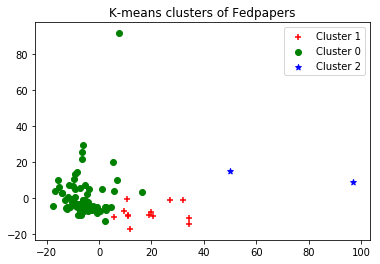

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(df_count_matrix)
pca_2d = pca.transform(df_count_matrix)




for i in range(0, pca_2d.shape[0]):
    if kmeansCluster.labels_[i] == 1:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='+')
    elif kmeansCluster.labels_[i] == 0:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='g',marker='o')
    elif kmeansCluster.labels_[i] == 2:
        c3 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='*')
plt.legend([c1, c2, c3],['Cluster 1', 'Cluster 0','Cluster 2'])
plt.title('K-means clusters of Fedpapers')
plt.show()

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)


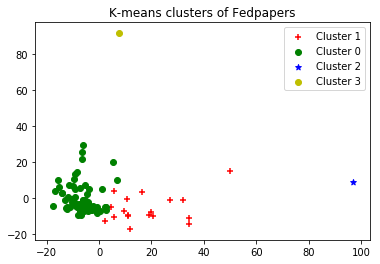

In [23]:
## 4 cluster assignment

## initialize the kmean cluster with 3 cluster assignment
kmeansCluster = KMeans(n_clusters=4)
print(kmeansCluster)

## fit the kmean cluster
kmeansCluster.fit(df_count_matrix)



for i in range(0, pca_2d.shape[0]):
    if kmeansCluster.labels_[i] == 1:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='+')
    elif kmeansCluster.labels_[i] == 0:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='g',marker='o')
    elif kmeansCluster.labels_[i] == 2:
        c3 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='*')
    elif kmeansCluster.labels_[i] == 3:
        c4 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='y',marker='o')
plt.legend([c1, c2, c3,c4],['Cluster 1', 'Cluster 0','Cluster 2','Cluster 3'])
plt.title('K-means clusters of Fedpapers')
plt.show()

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)


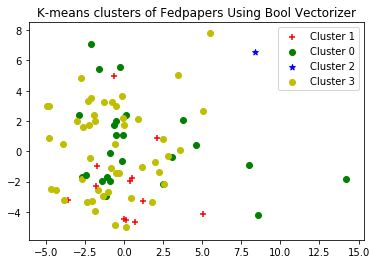

In [24]:
## bool vectorizer

df_bool_matrix = df_bool.values

## get the pca
pca = PCA(n_components=2).fit(df_bool_matrix)
pca_2d = pca.transform(df_bool_matrix )

## initialize the kmean cluster with 3 cluster assignment
kmeansCluster = KMeans(n_clusters=4)
print(kmeansCluster)

## fit the kmean cluster
kmeansCluster.fit(df_bool_matrix)



for i in range(0, pca_2d.shape[0]):
    if kmeansCluster.labels_[i] == 1:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='+')
    elif kmeansCluster.labels_[i] == 0:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='g',marker='o')
    elif kmeansCluster.labels_[i] == 2:
        c3 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='*')
    elif kmeansCluster.labels_[i] == 3:
        c4 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='y',marker='o')
plt.legend([c1, c2, c3,c4],['Cluster 1', 'Cluster 0','Cluster 2','Cluster 3'])
plt.title('K-means clusters of Fedpapers Using Bool Vectorizer')
plt.show()




KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)


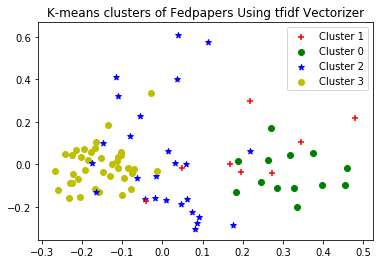

In [25]:
## tfidf vectorizer

df_tfidf_matrix = df_tfidf.values

## get the pca
pca = PCA(n_components=2).fit(df_tfidf_matrix)
pca_2d = pca.transform(df_tfidf_matrix )

## initialize the kmean cluster with 3 cluster assignment
kmeansCluster = KMeans(n_clusters=4)
print(kmeansCluster)

## fit the kmean cluster
kmeansCluster.fit(df_tfidf_matrix)



for i in range(0, pca_2d.shape[0]):
    if kmeansCluster.labels_[i] == 1:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='+')
    elif kmeansCluster.labels_[i] == 0:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='g',marker='o')
    elif kmeansCluster.labels_[i] == 2:
        c3 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='*')
    elif kmeansCluster.labels_[i] == 3:
        c4 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='y',marker='o')
plt.legend([c1, c2, c3,c4],['Cluster 1', 'Cluster 0','Cluster 2','Cluster 3'])
plt.title('K-means clusters of Fedpapers Using tfidf Vectorizer')
plt.show()

In [56]:
## AgglomerativeClustering

from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
cluster.fit_predict(df_tfidf_matrix)



array([2, 0, 0, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 1, 0, 3, 3, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2])

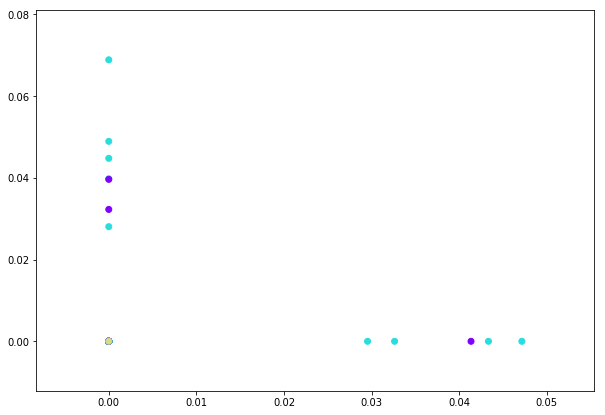

In [57]:
plt.figure(figsize=(10, 7))  
plt.scatter(df_tfidf_matrix[:,0], df_tfidf_matrix[:,1], c=cluster.labels_, cmap='rainbow') 

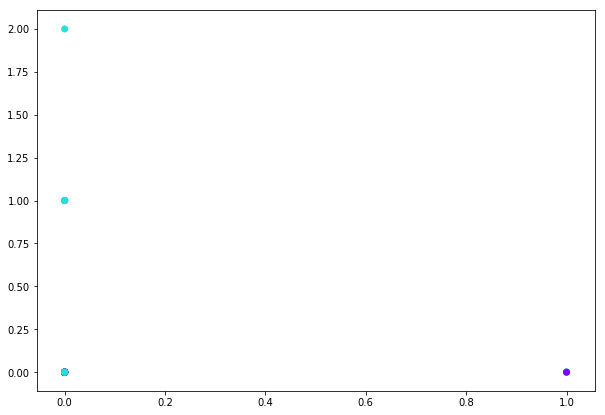

In [27]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
cluster.fit_predict(df_count_matrix)

plt.figure(figsize=(10, 7))  
plt.scatter(df_count_matrix[:,0], df_count_matrix[:,1], c=cluster.labels_, cmap='rainbow') 

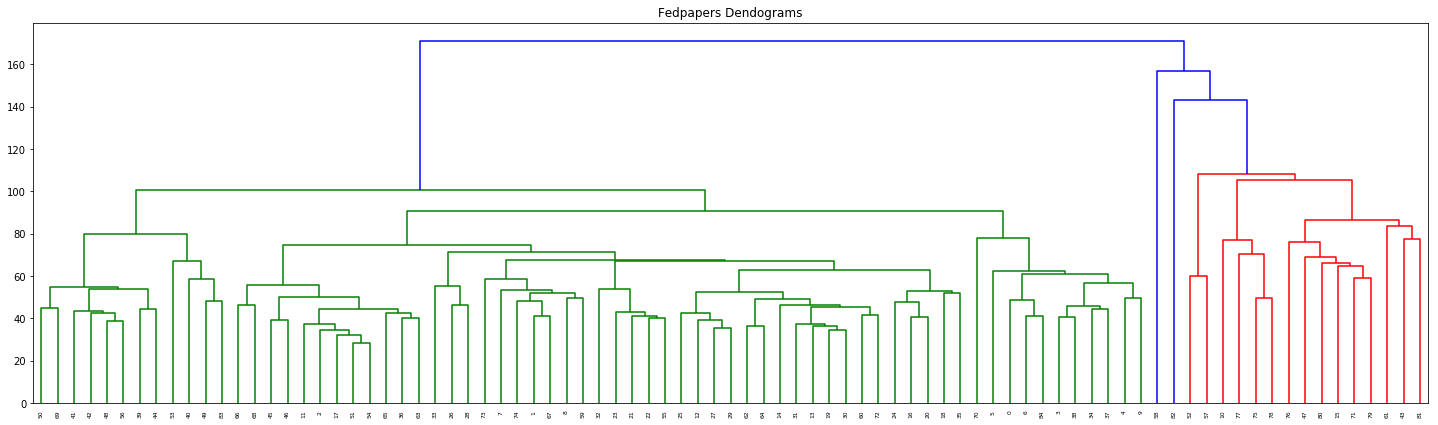

In [28]:
## hirachical cluster


import scipy.cluster.hierarchy as shc

plt.figure(figsize=(25, 7))  
plt.title("Fedpapers Dendograms")  
dend = shc.dendrogram(shc.linkage(df_count_matrix, method='ward')) 

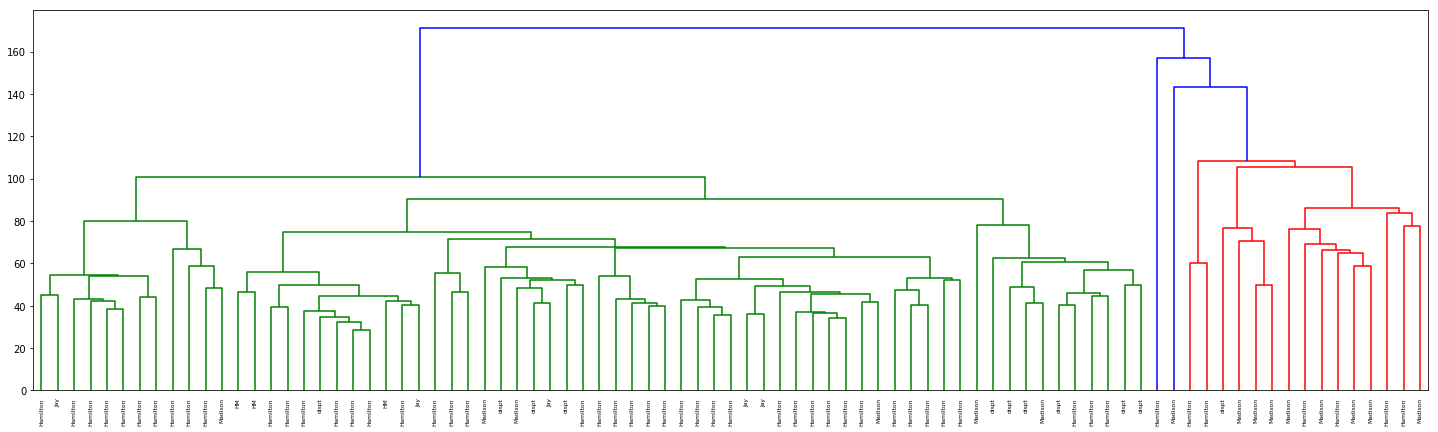

In [29]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt


linked = linkage(df_count_matrix, 'ward')


plt.figure(figsize=(25, 7))
dendrogram(
            linked,
            #orientation='left',
            labels=colnames,
            #distance_sort='descending',
            show_leaf_counts=False
          )
plt.show()

## Tf*idf Vectorizer

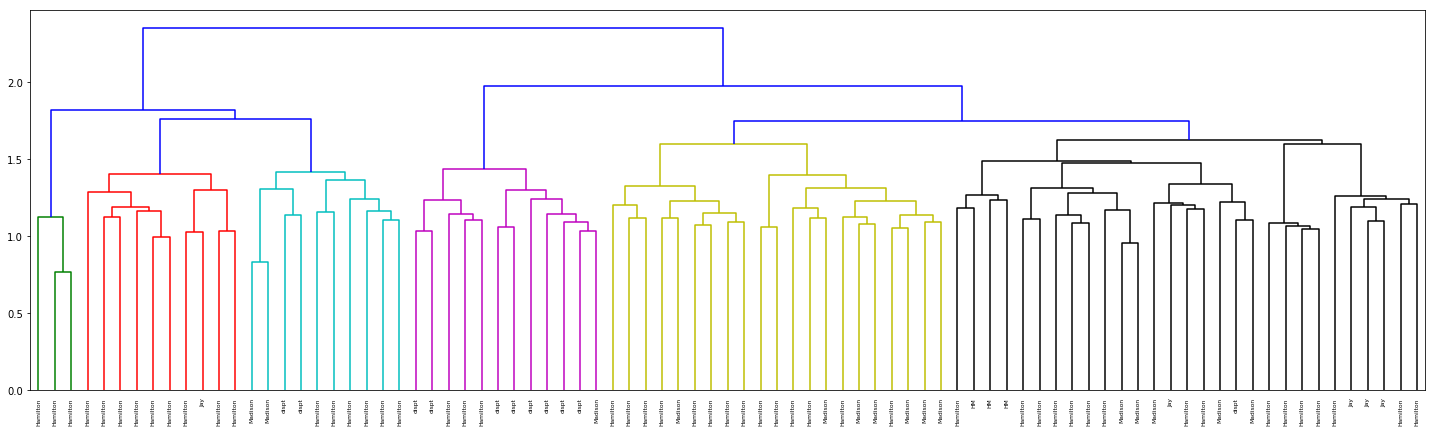

In [30]:
linked = linkage(df_tfidf_matrix, 'ward')


plt.figure(figsize=(25, 7))
dendrogram(
            linked,
            #orientation='left',
            labels=colnames,
            #distance_sort='descending',
            show_leaf_counts=False
          )
plt.show()

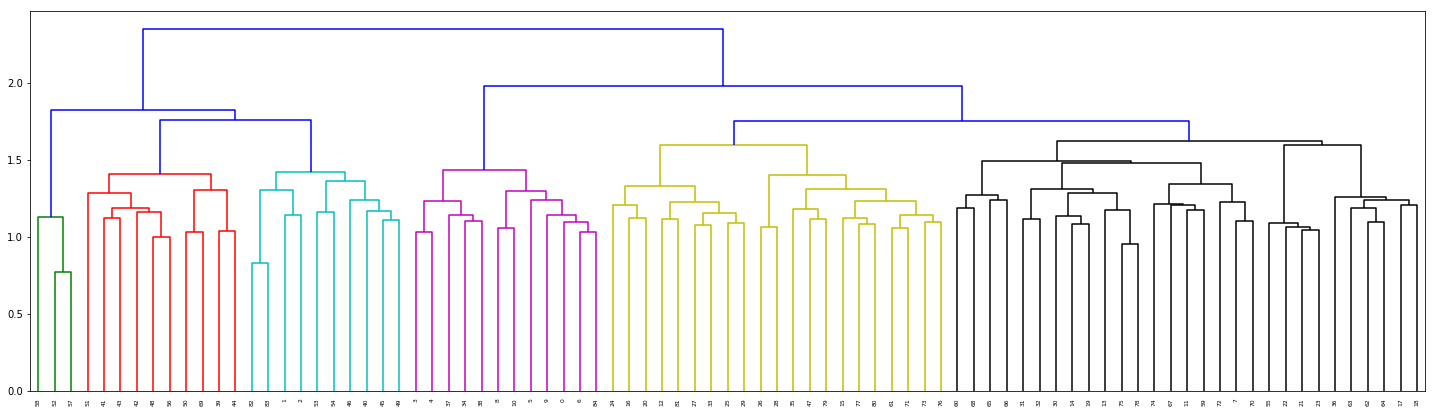

In [55]:
linked = linkage(df_tfidf_matrix, 'ward')


plt.figure(figsize=(25, 7))
dendrogram(
            linked,
            #orientation='left',
            #labels=colnames,
            distance_sort='descending',
            show_leaf_counts=False
          )
plt.show()

## Supervised ML

In [32]:
## Using Count vectorizer
## MNB required countvectorizer as input

## add label to the dataframe

df_count['label'] = colnames
df_bool['label'] = colnames
df_tfidf['label'] = colnames

df_count.head(15)

,abandon,abilities,ability,able,abolish,abolished,abolition,abridge,abridgment,abroad,absolute,absolutely,abstract,absurd,absurdity,abundant,abuse,abused,abuses,accidental,accommodated,accompanied,accomplish,accomplished,according,accordingly,account,accumulation,accuracy,accurate,accustomed,acknowledge,acknowledged,acquaintance,acquainted,acquire,acquired,acquisition,acting,action,...,wars,ways,weak,weaker,weakness,weal,wealth,wealthy,weight,weights,weighty,welfare,western,whilst,wholly,wide,willing,wisdom,wise,wisely,wish,wished,wishes,withstand,word,words,work,world,worse,worthy,writer,writers,wrong,year,years,yield,york,zeal,zealous,label
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0,0,0,0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,5,1,0,dispt
1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,2,0,0,dispt
2,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,dispt
3,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,9,1,2,1,0,dispt
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,1,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,3,0,2,1,0,dispt
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,dispt
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,8,0,3,0,0,dispt
7,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,1,5,1,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,dispt
8,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,4,1,1,0,0,dispt
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,dispt


In [0]:
## Train and Test set

train_count = df_count.iloc[11:]
#train_count.head()
test_count = df_count.iloc[:11]
test_count = test_count.drop(['label'],axis=1)
#test_count
y_train_count = train_count['label'].values
#y_train_count

## drop label fro train
train_count = train_count.drop(['label'], axis=1)
#train_count.head()

## Model

In [0]:
## model
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

In [51]:
## model 
svc = LinearSVC()

scores = cross_val_score(svc, train_count,y_train_count,cv=10)
print('Avg Score: {}'.format(sum(scores)/len(scores)))

Avg Score: 0.905


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


In [52]:
mnb = MultinomialNB()

scores = cross_val_score(mnb, train_count,y_train_count,cv=10)
print('Avg Score: {}'.format(sum(scores)/len(scores)))

Avg Score: 0.9136111111111109


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


In [53]:
mnb.fit(train_count, y_train_count)

prediction = mnb.predict(test_count)
prediction 

array(['Madison', 'Madison', 'Madison', 'Madison', 'Hamilton', 'Madison',
       'Madison', 'Madison', 'Madison', 'Madison', 'Madison'], dtype='<U8')

## Kappa

In [0]:
from sklearn.metrics import cohen_kappa_score

In [58]:
supervised = ['Madison', 'Madison', 'Madison', 'Madison', 'Hamilton', 'Madison','Madison', 'Madison', 'Madison', 'Madison', 'Madison']

## unsupervised using the dendogram
unsupervised = ['Madison', 'Madison', 'Madison', 'Hamilton', 'Hamilton', 'Madison','Madison', 'Madison', 'Madison', 'Madison', 'Madison']


cohen_kappa_score(supervised,unsupervised)

0.6206896551724137

In [59]:
svc = LinearSVC()

svc.fit(train_count, y_train_count)

svc_predict = svc.predict(test_count)
svc_predict

array(['Madison', 'Madison', 'Madison', 'Madison', 'Madison', 'Madison',
       'Madison', 'Madison', 'Madison', 'Hamilton', 'Madison'],
      dtype=object)

In [60]:
## kappa score between svc and mnb

sv = ['Madison', 'Madison', 'Madison', 'Madison', 'Madison', 'Madison','Madison', 'Madison', 'Madison', 'Hamilton', 'Madison']

mb = ['Madison', 'Madison', 'Madison', 'Madison', 'Hamilton', 'Madison','Madison', 'Madison', 'Madison', 'Madison', 'Madison']

cohen_kappa_score(sv,mb)

-0.10000000000000009

In [61]:
## between svc and cluster
cohen_kappa_score(sv,unsupervised)

-0.13793103448275867

### Topic Modeling

In [64]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [66]:
## Topic modeling

## Packages
import pandas as pd
import os
import numpy as np
np.random.seed(2018)
from argparse import ArgumentParser
import pyLDAvis.sklearn as LDAvis
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
import time
import nltk.stem

## slearn
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

start = time.time()
## eglish stemmer
english_stemmer = nltk.stem.SnowballStemmer('english')

## class to tem and vectorized doc
class StemmedCountVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([english_stemmer.stem(w) for w in analyzer(doc)])
    
    
## implement a print function 
## REF: https://nlpforhackers.io/topic-modeling/
def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])
    
    
##  stem vectorizer
stem_tfidf_vectorizer = StemmedCountVectorizer(input="filename",encoding='latin-1', binary=False, min_df=5, 
                                              stop_words='english',ngram_range=(1,2), analyzer="word",
                                              token_pattern='(?ui)\\b\\w*[a-z]{4,}\\w*\\b')


## get the list of folders list
    
folder = "FedCorpus_original"
allfilenames = []
for file in os.listdir(folder):
    filedir = folder + '/' + file
    #print(filedir)
    allfilenames.append(filedir)
        

## check some of the content of allfiles
print(allfilenames[:5])


## buid the model
num = 3  # initial number of topics based on literature
myvec = stem_tfidf_vectorizer.fit_transform(allfilenames)
# feature names
myvecfeature = stem_tfidf_vectorizer.get_feature_names()
vectDF = pd.DataFrame(myvec.toarray(),columns= myvecfeature)
print(vectDF.head())
## model
lda_model = LatentDirichletAllocation(n_components=num, max_iter=10, learning_method='online')
# fit the model
LDA = lda_model.fit_transform(myvec)
print("SIZE: ", LDA.shape) 
## print
print_topics(lda_model,stem_tfidf_vectorizer)

## viz
panel = LDAvis.prepare(lda_model, myvec, stem_tfidf_vectorizer, mds='tsne')
#pyLDAvis.show(panel)
vizname = 'lda_fedpaper_3' + '.html'
pyLDAvis.save_html(panel,vizname)

end = time.time()

print("Total Time: {}".format(end-start))

['FedCorpus_original/dispt_fed_57.txt', 'FedCorpus_original/dispt_fed_49.txt', 'FedCorpus_original/dispt_fed_50.txt', 'FedCorpus_original/dispt_fed_52.txt', 'FedCorpus_original/dispt_fed_53.txt']
   abandon      abil       abl  ...  york packet      zeal  zealous
0      0.0  0.000000  0.000000  ...     0.014726  0.022415      0.0
1      0.0  0.000000  0.042757  ...     0.019990  0.000000      0.0
2      0.0  0.000000  0.000000  ...     0.025591  0.000000      0.0
3      0.0  0.030842  0.018073  ...     0.016899  0.025723      0.0
4      0.0  0.000000  0.000000  ...     0.014345  0.021835      0.0

[5 rows x 2485 columns]
SIZE:  (85, 3)
Topic 0:
[('state', 12.394845099106929), ('govern', 8.455682811587252), ('power', 7.212767901136401), ('constitut', 5.79210427151065), ('nation', 5.447045657208539), ('peopl', 5.274122899380493), ('author', 3.985030691508452), ('union', 3.9548039896296117), ('senat', 3.810015257564481), ('execut', 3.7163807385845415)]
Topic 1:
[('state', 0.59131536707135

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
